# S&P 500 Time Series Momentum
This strategy calculates the 6m return of the S&P500 and invests in the index if the return is positive. 
Otherwise it will invest in 10yr Treasuries if its 6m return is positive. 
If neither have a positive trend then invest in T-Bills (3% annual return assumed)
Tranaction costs of 0.25% are taken each time a trade is placed.

In [297]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib
import matplotlib.pyplot as plt
import math
from datetime import datetime as dt
import random
import matplotlib.ticker as mtick

In [298]:
bond_df = pd.read_csv('Bonds.csv')
bond_df.set_index('Dates', inplace=True)
bond = bond_df['US_10yr']
bond.dropna(inplace=True)
bond = pd.DataFrame(bond)
bond.index = pd.to_datetime(bond.index, format = '%d/%m/%Y')
bond = bond.loc[bond.groupby(bond.index.to_period('M')).apply(lambda x: x.index.max())]
bond['TBond_Return'] = bond['US_10yr'].pct_change()

eq_df = pd.read_csv('Data.csv')
eq_df.set_index('Dates', inplace=True)
df = eq_df['S&P500']
df = pd.DataFrame(df)
df.index = pd.to_datetime(df.index, format = '%d/%m/%Y')
df = df.loc[df.groupby(df.index.to_period('M')).apply(lambda x: x.index.max())]
df['SPX_Return'] = df['S&P500'].pct_change()
df.dropna(inplace=True)

df = bond.merge(df, on='Dates')
df.dropna(inplace=True)
df

,US_10yr,TBond_Return,S&P500,SPX_Return
Dates,,,,
1982-06-30,69.562500,-0.037197,109.61,-0.020290
1982-07-30,72.343750,0.039982,107.09,-0.022991
1982-08-31,76.062500,0.051404,119.51,0.115977
1982-09-30,78.812500,0.036154,120.42,0.007614
1982-10-29,83.656250,0.061459,133.71,0.110364
...,...,...,...,...
2022-09-30,112.062500,-0.041176,3585.62,-0.093396
2022-10-31,110.593750,-0.013107,3871.98,0.079863
2022-11-30,113.218750,0.023736,4080.11,0.053753


In [299]:
df['Entry'] = ""
df['6mth_TSMOM'] = float(0)

# TSMOM
for i in range(6, df.shape[0]):
    if ((df['S&P500'][i-1] - df['S&P500'][i-6])/df['S&P500'][i-6]) >= 0:
        df['Entry'][i] = "SPX"
        df['6mth_TSMOM'][i] = df['SPX_Return'][i]
    elif ((df['US_10yr'][i-1] - df['US_10yr'][i-6])/df['US_10yr'][i-6]) >= 0:
        df['Entry'][i] = "10yr"
        df['6mth_TSMOM'][i] = df['TBond_Return'][i]
    else:
        df['Entry'][i] = "TBill"
        df['6mth_TSMOM'][i] = 0.0025

# Add Transaction costs
for i in range(df.shape[0]):
        if df['Entry'][i] != df['Entry'][i-1]:
            df.iloc[i,-1] -= 0.0025

df = df.tail(-6)
df.head()

,US_10yr,TBond_Return,S&P500,SPX_Return,Entry,6mth_TSMOM
Dates,,,,,,
1982-12-31,84.0625,0.014329,140.64,0.015158,SPX,0.012658
1983-01-31,82.8125,-0.014870,145.30,0.033134,SPX,0.033134
1983-02-28,85.9375,0.037736,148.06,0.018995,SPX,0.018995
1983-03-31,84.3125,-0.018909,152.96,0.033095,SPX,0.033095
1983-04-29,86.5000,0.025945,164.42,0.074922,SPX,0.074922


In [300]:
# Growth of $100
strategy = round((1+df['6mth_TSMOM']).cumprod() * 100, 0)
bmk = round((1+df['SPX_Return']).cumprod() * 100, 0)
print(strategy, bmk)

Dates
1982-12-31     101.0
1983-01-31     105.0
1983-02-28     107.0
1983-03-31     110.0
1983-04-29     118.0
               ...  
2022-09-30    2883.0
2022-10-31    2890.0
2022-11-30    2898.0
2022-12-30    2720.0
2023-01-31    2720.0
Name: 6mth_TSMOM, Length: 482, dtype: float64 Dates
1982-12-31     102.0
1983-01-31     105.0
1983-02-28     107.0
1983-03-31     110.0
1983-04-29     119.0
               ...  
2022-09-30    2588.0
2022-10-31    2795.0
2022-11-30    2945.0
2022-12-30    2771.0
2023-01-31    2943.0
Name: SPX_Return, Length: 482, dtype: float64


            Strategy_Rolling_Ret  Bmk_Rolling_Ret
Dates                                            
2022-09-30              0.096777        -0.167594
2022-10-31              0.028411        -0.159249
2022-11-30              0.039646        -0.106610
2022-12-30             -0.065039        -0.194428
2023-01-31             -0.013145        -0.097209


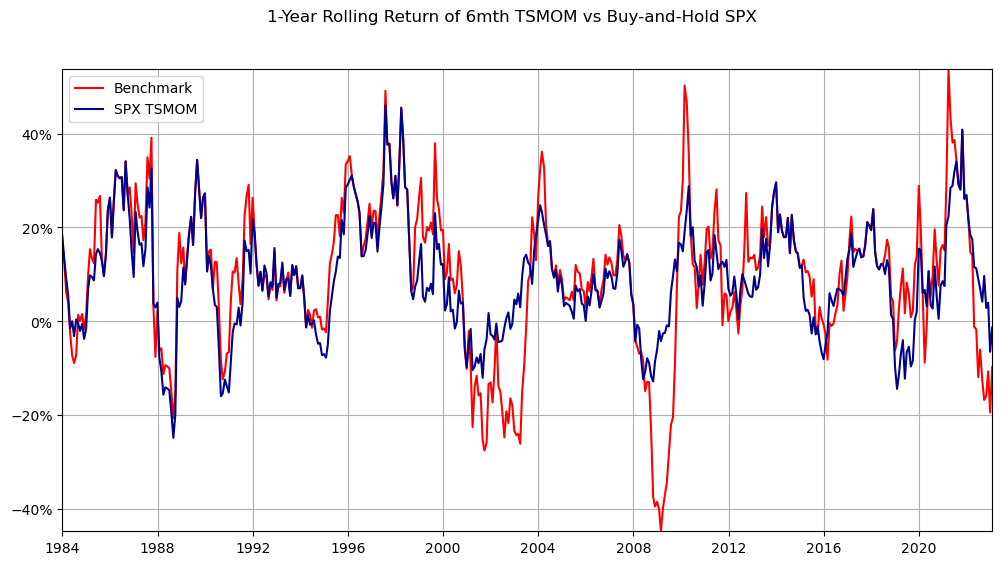

In [301]:
## 1yr rolling return
df['Strategy_Rolling_Ret'] = (1+df["6mth_TSMOM"]).rolling(window=12).apply(np.prod, raw=True) - 1    
df['Bmk_Rolling_Ret'] = df['S&P500'].pct_change(periods=12, axis=0).dropna(axis=0)
df.dropna(inplace=True)
print(df.iloc[:,-2:].tail())

fig = plt.figure(figsize=(12, 6))
fig.suptitle('1-Year Rolling Return of 6mth TSMOM vs Buy-and-Hold SPX')

ax = fig.add_subplot(111)
ax.plot(df['Bmk_Rolling_Ret'], color='red', label='Benchmark')
ax.plot(df['Strategy_Rolling_Ret'], color='darkblue', label='SPX TSMOM')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.set_ylim(min(list(df['Bmk_Rolling_Ret'])+list(df['Strategy_Rolling_Ret'])),max(list(df['Bmk_Rolling_Ret'])+list(df['Strategy_Rolling_Ret'])))
ax.set_xlim(min(df.index),max(df.index))
ax.grid()
ax.legend(loc=0)

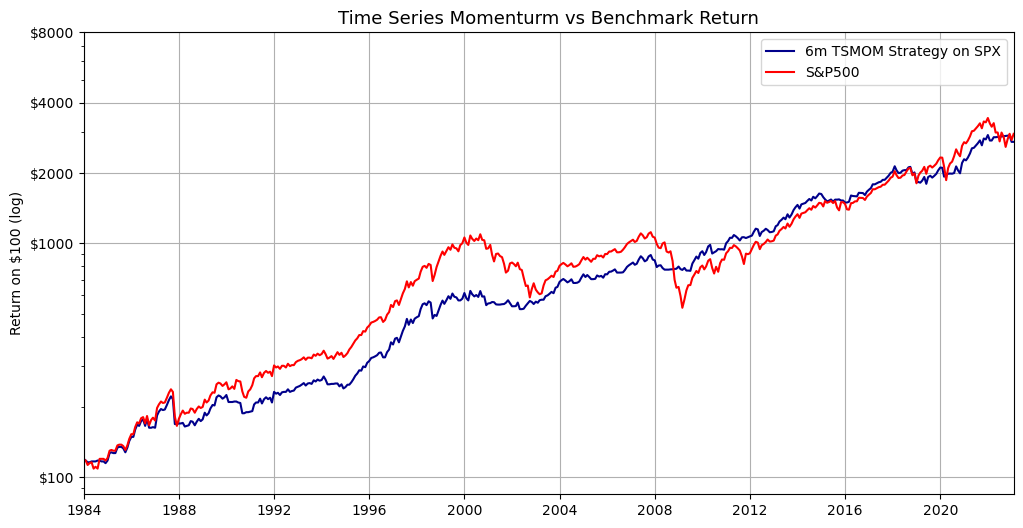

In [302]:
d = {'Strategy':strategy, 'Benchmark': bmk}
df2 = pd.DataFrame(data=d)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strategy, label="6m TSMOM Strategy on SPX", color="darkblue")
ax.plot(bmk, label="S&P500", color="red")
ax.set_title('Time Series Momenturm vs Benchmark Return',fontsize=13)
ax.set_ylabel('Return on $100 (log)')
ax.set_yscale('log')
ax.set_yticks([100,1000, 2000, 4000, 8000])
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(min(df.index),max(df.index))
ax.grid()
ax.legend(loc=0)

Strategy:
Max Drawdown:-25.68%
Max Drawdown Duration: 42 days
Date of Max DrawDown: 1988-03-31 00:00:00

_____________

Benchmark:
Max Drawdown:-52.5%
Max Drawdown Duration: 80 days
Date of Max DrawDown: 2009-02-27 00:00:00

_____________



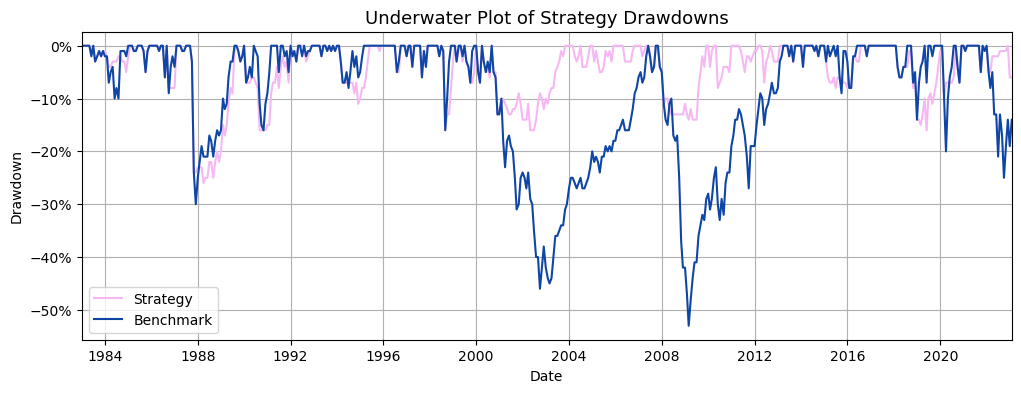

In [303]:
# DD and Return Stats
def calculate_MaxDD(dataframe, multi_frame=False, num_frames=1):
    """
    Calculates the drawdown statistics for an asset or strategy
    """
    if multi_frame==False:
        cumreturn = dataframe
        highwatermark = np.zeros(cumreturn.shape)
        drawdown = np.zeros(cumreturn.shape)
        drawdownduration = np.zeros(cumreturn.shape)

        for t in np.arange(1, cumreturn.shape[0]):
            highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
            drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
            if drawdown[t] == 0:
                drawdownduration[t] = 0
            else:
                drawdownduration[t] = drawdownduration[t - 1] + 1

        maxDD, i = np.min(drawdown), np.argmin(drawdown)
        maxDDD = np.max(drawdownduration)
        DD_Date = cumreturn.index[i]
        return f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}"
    
    else:
        for i in range(num_frames): 
            cumreturn = dataframe.iloc[:,i]
            highwatermark = np.zeros(cumreturn.shape)
            drawdown = np.zeros(cumreturn.shape)
            drawdownduration = np.zeros(cumreturn.shape)

            for t in np.arange(1, cumreturn.shape[0]):
                highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
                drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
                if drawdown[t] == 0:
                    drawdownduration[t] = 0
                else:
                    drawdownduration[t] = drawdownduration[t - 1] + 1

            maxDD, i = np.min(drawdown), np.argmin(drawdown)
            maxDDD = np.max(drawdownduration)
            DD_Date = cumreturn.index[i]
            print(f"{cumreturn.name}:")
            print(f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}\n")
            print("_____________\n")
    
def underwater_plot(dataframe, multi_frame=False, num_frames=1):
    """
    Plots the drawdown profile of an asset from the asset price dataframe
    """
    if multi_frame==False:
        cum_max = dataframe.cummax()
        drawdowns = (dataframe - cum_max) / cum_max
        drawdowns = round(drawdowns,2)
        
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(drawdowns.index, drawdowns, color="lightcoral")
        ax.fill_between(drawdowns.index, drawdowns, 0, where=drawdowns < 0, interpolate=True, color="whitesmoke")
        ax.set_title('Underwater Plot of Strategy Drawdowns',fontsize=13)
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown')
        ax.grid()
        ax.set_xlim(min(dataframe.index),max(dataframe.index))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    else:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Underwater Plot of Strategy Drawdowns',fontsize=13)
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown')
        for i in range(num_frames): 
            cum_max = dataframe.iloc[:,i].cummax()
            drawdowns = (dataframe.iloc[:,i] - cum_max) / cum_max
            drawdowns = round(drawdowns,2)
            ax.plot(drawdowns.index, drawdowns, color=list(np.random.uniform(0,1, size=3)), label=dataframe.columns[i])
        ax.legend(loc=0)
        ax.grid()
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
        ax.set_xlim(min(dataframe.index),max(dataframe.index))


underwater_plot(df2, multi_frame=True, num_frames=2)
calculate_MaxDD(df2, multi_frame=True, num_frames=2)

            Strategy_Rolling_6m_Ret  Bmk_Rolling_6m_Ret  Strategy_Rolling_vol  \
Dates                                                                           
2022-09-30                    0.097              -0.168                 0.099   
2022-10-31                    0.028              -0.159                 0.076   
2022-11-30                    0.040              -0.107                 0.075   
2022-12-30                   -0.065              -0.194                 0.086   
2023-01-31                   -0.013              -0.097                 0.070   

            Bmk_Rolling_vol  
Dates                        
2022-09-30            0.217  
2022-10-31            0.222  
2022-11-30            0.232  
2022-12-30            0.230  
2023-01-31            0.238  


<function matplotlib.pyplot.show(close=None, block=None)>

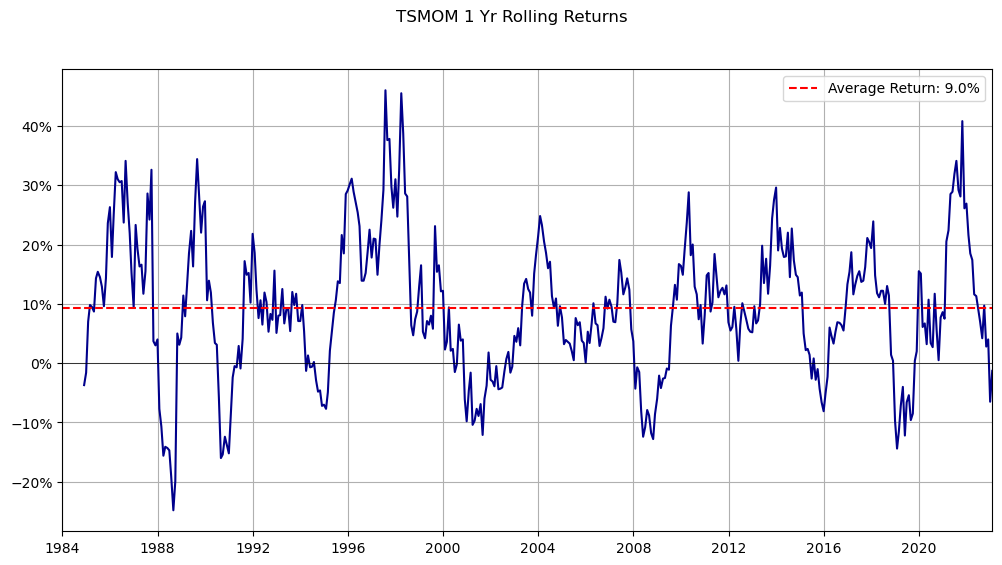

In [304]:
# Calculating the Sharpe
# 1yr rolling returns and vol
df['Strategy_Rolling_6m_Ret'] = round(((1+df["6mth_TSMOM"]).rolling(12).apply(np.prod, raw=True) - 1),3)
df['Bmk_Rolling_6m_Ret'] = round(df['S&P500'].pct_change(periods=12, axis=0).dropna(axis=0),3)

df['Strategy_Rolling_vol'] = round(df['6mth_TSMOM'].rolling(12).apply(np.std, raw=True)*(12**0.5),3) #scaling to yearly vol
df['Bmk_Rolling_vol'] = round(df['SPX_Return'].rolling(12).std()*(12**0.5), 3) #pct_change(periods=12, axis=0)
print(df.iloc[:,-4:].tail())

fig = plt.figure(figsize=(12, 6))
fig.suptitle('TSMOM 1 Yr Rolling Returns')

ax = fig.add_subplot(111)
ax.plot(df['Strategy_Rolling_6m_Ret']*100, color='darkblue')
ax.axhline(y=(df['Strategy_Rolling_6m_Ret'].mean()*100), color='red', ls='--', lw=1.5, label="Average Return: " + str(round(df['Strategy_Rolling_6m_Ret'].mean()*100,0)) + "%")
ax.axhline(y=0, color='black', lw=0.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlim(min(df.index),max(df.index))
plt.legend(loc='best')
plt.grid()
plt.show

In [305]:
# Adding a risk-free rate
rfr = pd.read_csv('Bonds.csv')
rfr.set_index('Dates', inplace=True)
rfr.drop(columns=['US_10yr', 'US_2yr', 'US_20yr', 'VIX Index', 'Bond_VIX', 'FX_VIX', 'US_3mth'], inplace=True)
rfr.fillna(value=6, inplace=True) #backfilling risk-free rate assuming a constant 6%
rfr.index = pd.to_datetime(rfr.index, format = '%d/%m/%Y') 
rfr = rfr.loc[rfr.groupby(rfr.index.to_period('M')).apply(lambda x: x.index.max())]
rfr = rfr/100
print(rfr)

df = df.merge(rfr, on='Dates')
df.dropna(inplace=True)
df.head()

             US_1mth
Dates               
1900-01-31  0.060000
1900-02-28  0.060000
1900-03-31  0.060000
1900-04-30  0.060000
1900-05-31  0.060000
...              ...
2022-12-30  0.043916
2023-01-31  0.045743
2023-02-28  0.046694
2023-03-31  0.048577
2023-04-26  0.050161

[1480 rows x 1 columns]


,US_10yr,TBond_Return,S&P500,SPX_Return,Entry,6mth_TSMOM,Strategy_Rolling_Ret,Bmk_Rolling_Ret,Strategy_Rolling_6m_Ret,Bmk_Rolling_6m_Ret,Strategy_Rolling_vol,Bmk_Rolling_vol,US_1mth
Dates,,,,,,,,,,,,,
1984-12-31,79.84375,-0.008152,167.24,0.022374,SPX,0.022374,-0.015816,0.014006,-0.016,0.014,0.035,0.140,0.0850
1985-01-31,82.12500,0.028571,179.63,0.074085,SPX,0.074085,0.069629,0.099260,0.070,0.099,0.079,0.156,0.0863
1985-02-28,78.75000,-0.041096,181.18,0.008629,SPX,0.008629,0.097887,0.153572,0.098,0.154,0.075,0.148,0.0900
1985-03-29,79.43750,0.008730,180.66,-0.002870,SPX,-0.002870,0.094736,0.134942,0.095,0.135,0.075,0.148,0.0888
1985-04-30,81.06250,0.020456,179.83,-0.004594,SPX,-0.004594,0.086989,0.123586,0.087,0.124,0.076,0.149,0.0850


6mth TSMOM Av. Vol:  10.39 %
SPX Av. Vol:  14.01 %


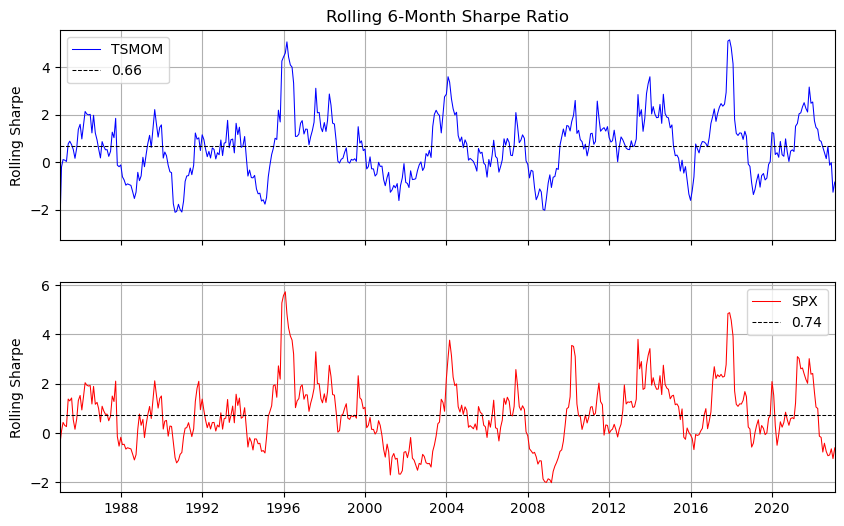

In [306]:
# Plot rolling 6 month sharpe ratio
strat_return = df['Strategy_Rolling_6m_Ret']
strat_vol = df['Strategy_Rolling_vol'] 
strategy_sharpe = (strat_return - df['US_1mth']) / strat_vol

for i in range(len(strategy_sharpe)):
    if strategy_sharpe[i] < -5:
        strategy_sharpe[i] = -3

# plotting the sharpe ratio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True) 
ax1.title.set_text('Rolling 6-Month Sharpe Ratio')
ax1.plot(strategy_sharpe, label='TSMOM', color='blue', lw=0.75)
ax1.axhline(y=strategy_sharpe.mean(), lw=0.75, ls='--', color='black', label=round(strategy_sharpe.mean(), 2))
ax1.set_ylabel('Rolling Sharpe')
ax2.set_xlim(min(df.index),max(df.index))
ax1.grid()
ax1.legend(loc='best')

# calculating SPX sharpe ratio
bmk_return = df['Bmk_Rolling_6m_Ret']
bmk_vol = df['Bmk_Rolling_vol'] 
bmk_sharpe = (bmk_return - df['US_1mth']) / bmk_vol

# plotting the sharpe ratio
ax2.plot(bmk_sharpe, label='SPX', color='red', lw=0.75)
ax2.axhline(y=bmk_sharpe.mean(), lw=0.75, ls='--', color='black', label=round(bmk_sharpe.mean(), 2))
ax2.set_ylabel('Rolling Sharpe')
ax2.set_xlim(min(df.index),max(df.index))
ax2.grid()
ax2.legend(loc='best')

print('6mth TSMOM Av. Vol: ', round(strat_vol.mean()*100,2),'%')
print('SPX Av. Vol: ', round(bmk_vol.mean()*100,2),'%')